## Kaggle competition. Sales prediction using ML.

Competition is available at the link https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

We need to forecast the number of good which will be sold in each shop next month.

#### Let's start by loading data.

In [1]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#подгружаем данные с kaggle
!kaggle competitions download -c competitive-data-science-predict-future-sales

Saving kaggle.json to kaggle (4).json
-rw-r--r-- 1 root root 72 Dec 23 09:42 kaggle.json
item_categories.csv: Skipping, found more recently modified local copy (use --force to force download)
items.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sales_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
shops.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
#подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

import seaborn as sns
import sys
import itertools
import gc

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import csv
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import datetime
from itertools import product
import statsmodels.api

In [3]:
items = pd.read_csv('items.csv.zip')
categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
train = pd.read_csv('sales_train.csv.zip')
sample=pd.read_csv('sample_submission.csv.zip')
test=pd.read_csv('test.csv.zip')

### Data preprocessing: let's start with **train** dataset.


In [4]:
#приводим даты к типу datetime
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

#убираем возможные выбросы - где цена товара меньше 0 
#если количество проданных товаров меньше 0 - заменяем на 0 (возможно, это были возвраты, тогда продажи по этим наблюдениям равны 0)
train = train[train["item_price"] >= 0]
train[train["item_cnt_day"] < 0] = 0

#убираем значения, которые выходят на 97% квантиль (там есть очень большие выбросы, но их не много)
cols = ['item_price', 'item_cnt_day'] 
Q = train[cols].quantile(0.97)
train = train[(train[cols] < Q).any(axis=1)]

train.shape

(2931258, 6)

In [5]:
#оставляем только те магазины, которые есть в тестовой выборке
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
#train = train.loc[train.item_id.isin(test["item_id"].unique()), :]

In [6]:
#добавляем стобцы days, months, years
days = []
months = []
years = []

for day in train['date']:
    days.append(day.day)
for month in train['date']:
    months.append(month.month)    

train['day'] = days
train['month'] = months
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month
0,2013-01-02 00:00:00,0,59,22154,999.00,1.0,2,1
1,2013-01-03 00:00:00,0,25,2552,899.00,1.0,3,1
3,2013-01-06 00:00:00,0,25,2554,1709.05,1.0,6,1
4,2013-01-15 00:00:00,0,25,2555,1099.00,1.0,15,1
5,2013-01-10 00:00:00,0,25,2564,349.00,1.0,10,1


#### Now let's work with additional data - in tables **items, categories, shops**.

In [7]:
for shop_id in shops['shop_id'].unique():
    #считаем количество товаров в магазине
    shops.loc[shop_id, 'num_products'] = train[train['shop_id'] == shop_id]['item_id'].nunique()
    #считаем среднюю цену товара (для разных id товаров) в магазине
    shops.loc[shop_id, 'mean_price'] = train[train['shop_id'] == shop_id]['item_price'].mean()

#выделим город как признак
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])
shops['city']=shops['city'].str.replace('!Якутск','Якутск')
shops['city']=shops['city'].factorize()[0]
shops.head()

,shop_name,shop_id,num_products,mean_price,city
0,"!Якутск Орджоникидзе, 56 фран",0,0.0,NaN,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0.0,NaN,0
2,"Адыгея ТЦ ""Мега""",2,4849.0,1329.814062,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,5261.0,1024.915414,2
4,"Волжский ТЦ ""Волга Молл""",4,7308.0,918.587342,3


In [8]:
#выделим главную категорию из названия("Аксессуары - PS2" и "Аксессуары - PS3" - это все Аксессуары) и сохраним в столбец cat_main
categories['cat_main']=categories['item_category_name'].apply(lambda x: x.split('-')[0])
categories['cat_main'] = categories['cat_main'].factorize()[0]
categories.head()

,item_category_name,item_category_id,cat_main
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1


In [9]:
#в этом датасете не будем генерировать доп признаки
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
#создаем шаблон для матрицы
indexlist = []
for i in train.date_block_num.unique():
  x = itertools.product(
            [i],
            train.loc[train.date_block_num == i].shop_id.unique(),
            train.loc[train.date_block_num == i].item_id.unique(),
        )
  indexlist.append(np.array(list(x)))
df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

In [11]:
#добавим больше признаков в train
train["item_revenue_day"] = train["item_price"] * train["item_cnt_day"]
train_grouped = train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
        #первый месяц продаж товара в магазине
        item_min_month=pd.NamedAgg(column="month", aggfunc="min"),
        #здесь средняя цена конкретного товара
        item_mean_price=pd.NamedAgg(column="item_price", aggfunc="mean")).reset_index()
df = df.merge(train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"])
df.head()   

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_min_month,item_mean_price
0,0,59,22154,1.0,999.0,1.0,999.0
1,0,59,2552,NaN,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN,NaN


In [12]:
#подготовим итоговый датасет
test["date_block_num"] = 34
test = test.drop(columns="ID")
final = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])
final.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_min_month,item_mean_price
0,0,59,22154,1.0,999.0,1.0,999.0
1,0,59,2552,NaN,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN,NaN


In [13]:
final.item_cnt_month = final.item_cnt_month.fillna(0)
final.item_revenue_month = final.item_revenue_month.fillna(0) 
final.item_min_month = final.item_min_month.fillna(0)
final.item_mean_price = final.item_mean_price.fillna(0) 

In [14]:
#объединяем данные
items_more=items.merge(categories[['item_category_id','cat_main']], on='item_category_id', how='left')
final = final.merge(shops[['shop_id','city','num_products','mean_price']], on='shop_id', how='left')
final = final.merge(items_more[['item_id','item_category_id', 'cat_main']], on='item_id', how='left')

In [15]:
#преобразуем данные, чтобы матрица занимала меньше места в памяти
matrix=final
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix['item_min_month'] = matrix['item_min_month'].astype(np.int8)
matrix['item_mean_price'] = matrix['item_mean_price'].astype(np.int32)
matrix['item_cnt_month'] = matrix['item_cnt_month'].astype(np.int32)
matrix['item_revenue_month'] = matrix['item_revenue_month'].astype(np.int32)
matrix['mean_price'] = matrix['mean_price'].astype(np.int32)
matrix['mean_price'] = matrix['mean_price'].astype(np.int32)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['city'] = matrix['city'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['cat_main'] = matrix['cat_main'].astype(np.int8)
matrix['num_products'] = matrix['num_products'].astype(np.int32)
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0, 20)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_min_month,item_mean_price,city,num_products,mean_price,item_category_id,cat_main
0,0,59,22154,1,999,1,999,30,7334,874,37,11
1,0,59,2552,0,0,0,0,30,7334,874,58,13
2,0,59,2554,0,0,0,0,30,7334,874,58,13
3,0,59,2555,0,0,0,0,30,7334,874,56,13
4,0,59,2564,0,0,0,0,30,7334,874,59,13
...,...,...,...,...,...,...,...,...,...,...,...,...
8807732,34,45,18454,0,0,0,0,21,7299,929,55,13
8807733,34,45,16188,0,0,0,0,21,7299,929,64,14
8807734,34,45,15757,0,0,0,0,21,7299,929,55,13
8807735,34,45,19648,0,0,0,0,21,7299,929,40,11


#### Now we move to building forecasting models.

In [16]:
# функция для добавления спец признаков - lags
def lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
    return matrix

In [17]:
#добавляем лаги
matrix1 = lag_feature(matrix, 'item_cnt_month', lags=[1,2,3])
matrix1 = lag_feature(matrix1, 'item_revenue_month', lags=[1])
matrix1

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_revenue_month_lag_1


,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_min_month,item_mean_price,city,num_products,mean_price,item_category_id,cat_main,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_revenue_month_lag_1
0,0,59,22154,1,999,1,999,30,7334,874,37,11,NaN,NaN,NaN,NaN
1,0,59,2552,0,0,0,0,30,7334,874,58,13,NaN,NaN,NaN,NaN
2,0,59,2554,0,0,0,0,30,7334,874,58,13,NaN,NaN,NaN,NaN
3,0,59,2555,0,0,0,0,30,7334,874,56,13,NaN,NaN,NaN,NaN
4,0,59,2564,0,0,0,0,30,7334,874,59,13,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8807732,34,45,18454,0,0,0,0,21,7299,929,55,13,1.0,0.0,0.0,99.0
8807733,34,45,16188,0,0,0,0,21,7299,929,64,14,0.0,0.0,NaN,0.0
8807734,34,45,15757,0,0,0,0,21,7299,929,55,13,0.0,0.0,0.0,0.0
8807735,34,45,19648,0,0,0,0,21,7299,929,40,11,0.0,0.0,0.0,0.0


In [18]:
#уберем период, где не хватает данных
matrix1.fillna(0, inplace= True)
matrix1 = matrix1[matrix1.date_block_num>=12] 
matrix1.reset_index(drop=True, inplace=True)
matrix1

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_min_month,item_mean_price,city,num_products,mean_price,item_category_id,cat_main,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_revenue_month_lag_1
0,12,55,492,20,73800,1,600,28,1985,607,76,15,20.0,20.0,20.0,54900.0
1,12,55,490,1,188,1,188,28,1985,607,78,15,0.0,1.0,1.0,0.0
2,12,55,488,1,188,1,188,28,1985,607,78,15,1.0,1.0,1.0,188.0
3,12,55,446,1,172,1,172,28,1985,607,44,12,0.0,0.0,0.0,0.0
4,12,55,132,1,216,1,216,28,1985,607,44,12,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456443,34,45,18454,0,0,0,0,21,7299,929,55,13,1.0,0.0,0.0,99.0
5456444,34,45,16188,0,0,0,0,21,7299,929,64,14,0.0,0.0,0.0,0.0
5456445,34,45,15757,0,0,0,0,21,7299,929,55,13,0.0,0.0,0.0,0.0
5456446,34,45,19648,0,0,0,0,21,7299,929,40,11,0.0,0.0,0.0,0.0


Divide the sample into train, validation and test.

In [19]:
df=matrix1
dropcols = [
   "shop_id",
   "item_id"
] 

In [20]:
keep_from_month = 12  
valid_month = 33
valid = df.loc[df.date_block_num == valid_month, :]
train = df.loc[df.date_block_num < valid_month, :]
train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_valid = valid.drop(columns="item_cnt_month")
y_valid = valid.item_cnt_month
test = df.drop(columns="item_cnt_month").loc[df.date_block_num == 34, :]

### The first model - **Logistic regression**.

In [51]:
#поставим значения интуитивно 
model_lgb = LGBMRegressor(colsample_bytree=0.9,learning_rate=0.01, max_depth=8,
              n_estimators=30000, num_leaves=700, reg_alpha=0.04, subsample=0.6)

In [54]:
categoricals=["item_category_id","month"]

lgbm = model_lgb.fit(X_train, 
                     y_train,
                     eval_set = [(X_train, y_train), (X_valid, y_valid)],
                     eval_metric ='rmse',
                     categorical_feature = [c for c in categoricals if c in X_train.columns],
                     early_stopping_rounds = 50,
                     verbose = 100)

Training until validation scores don't improve for 50 rounds.
[100]	training's l2: 0.217969	training's rmse: 0.466871	valid_1's l2: 0.164491	valid_1's rmse: 0.405575
[200]	training's l2: 0.037588	training's rmse: 0.193876	valid_1's l2: 0.0288183	valid_1's rmse: 0.16976
[300]	training's l2: 0.00984428	training's rmse: 0.0992184	valid_1's l2: 0.00746981	valid_1's rmse: 0.0864281
[400]	training's l2: 0.00426243	training's rmse: 0.0652873	valid_1's l2: 0.00299773	valid_1's rmse: 0.0547515
[500]	training's l2: 0.0030076	training's rmse: 0.0548416	valid_1's l2: 0.00193108	valid_1's rmse: 0.043944
[600]	training's l2: 0.00254615	training's rmse: 0.0504594	valid_1's l2: 0.00156498	valid_1's rmse: 0.0395598
[700]	training's l2: 0.00233035	training's rmse: 0.0482737	valid_1's l2: 0.0014235	valid_1's rmse: 0.0377292
[800]	training's l2: 0.0022027	training's rmse: 0.0469329	valid_1's l2: 0.00137012	valid_1's rmse: 0.0370152
[900]	training's l2: 0.00211538	training's rmse: 0.0459933	valid_1's l2: 0

In [55]:
#возможно, модель стоило обучить еще...но дедлайн в 18:00 не позволяет нам 
lgbm.best_score_

defaultdict(dict,
            {'training': {'l2': 0.0015032304026217037,
              'rmse': 0.038771515351114456},
             'valid_1': {'l2': 0.0011628610975446018,
              'rmse': 0.034100749222628554}})

In [58]:
#предсказываем на тестовой
sales_prediction = model_lgb.predict(test)

In [59]:
#проверим качество на тестовой выборке и сохраним результат
test=test=pd.read_csv('test.csv.zip')
test_result= pd.DataFrame(sales_prediction)
test_result.columns = ['item_cnt_month']
predict = test_result['item_cnt_month']
sales_predict_submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':predict})
sales_predict_submission.to_csv('submission_log_reg.csv', index=False)

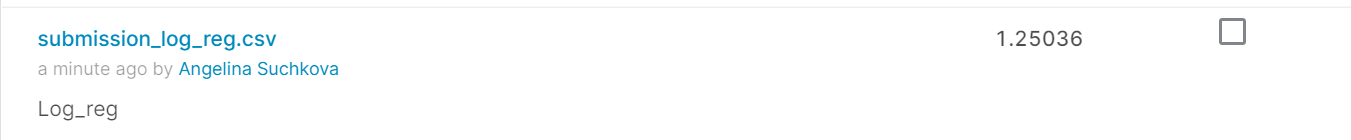


### Now try to train model **XGBoost**. Start with cross validation to choose the correct parameters.

In [21]:
#в целом будем использовать тот же датасет matrix1 (мы его сохранили в df)
#но для кросс-валидации необходимо поделить данные на мелкие выборки
#используем только последние 6 месяцев, иначе модель будет обучаться слишком долго
splits = []
for block in [27, 28, 29, 30, 31, 32]:
    train_idxs = df[df.date_block_num < block].index.values
    test_idxs = df[df.date_block_num == block].index.values
    splits.append((train_idxs, test_idxs))
splits

[(array([      0,       1,       2, ..., 3744772, 3744773, 3744774]),
  array([3744775, 3744776, 3744777, ..., 3966172, 3966173, 3966174])),
 (array([      0,       1,       2, ..., 3966172, 3966173, 3966174]),
  array([3966175, 3966176, 3966177, ..., 4178675, 4178676, 4178677])),
 (array([      0,       1,       2, ..., 4178675, 4178676, 4178677]),
  array([4178678, 4178679, 4178680, ..., 4389005, 4389006, 4389007])),
 (array([      0,       1,       2, ..., 4389005, 4389006, 4389007]),
  array([4389008, 4389009, 4389010, ..., 4604296, 4604297, 4604298])),
 (array([      0,       1,       2, ..., 4604296, 4604297, 4604298]),
  array([4604299, 4604300, 4604301, ..., 4812617, 4812618, 4812619])),
 (array([      0,       1,       2, ..., 4812617, 4812618, 4812619]),
  array([4812620, 4812621, 4812622, ..., 5020569, 5020570, 5020571]))]

In [22]:
X_train.drop('date_block_num', axis=1, inplace=True)
X_valid.drop('date_block_num', axis=1, inplace=True)
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
X_test.drop('date_block_num', axis=1, inplace=True)

In [23]:
#определим параметры, из которых будем выбирать
hyper_params = {'max_depth': [3, 5, 8], 
                'gamma': [0, 0.5, 1, 2, 5], 
                'subsample': [0.6, 0.8, 1], 
                'colsample_bytree': [0.5, 0.7, 0.9], 
                'learning_rate': [0.01, 0.1, 0.2],
                'max_bin' : [256, 512]
               }

xgbr = XGBRegressor(seed = 13, tree_method = "hist")

In [69]:
clf = RandomizedSearchCV(estimator = xgbr, 
                   param_distributions = hyper_params,
                   n_iter = 2,
                   scoring = 'neg_root_mean_squared_error',
                   cv = splits,
                   verbose=3)
clf.fit(X_train, y_train)

Fitting 6 folds for each of 2 candidates, totalling 12 fits
[13:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/6] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_bin=256, max_depth=5, subsample=0.6;, score=-0.604 total time= 1.7min
[13:31:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/6] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_bin=256, max_depth=5, subsample=0.6;, score=-0.528 total time= 1.7min
[13:33:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/6] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_bin=256, max_depth=5, subsample=0.6;, score=-0.533 total time= 1.8min
[13:35:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 4/6] END colsa

RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 3744772, 3744773, 3744774]),
                        array([3744775, 3744776, 3744777, ..., 3966172, 3966173, 3966174])),
                       (array([      0,       1,       2, ..., 3966172, 3966173, 3966174]),
                        array([3966175, 3966176, 3966177, ..., 4178675, 4178676, 4178677])),
                       (array([      0,       1,       2, ..., 4178675, 4178676, 4178677]),
                        array([4178678, 4178679, 4178680, ..., 4389005, 4389006, 4389007])),
                       (array([      0...
                       (array([      0,       1,       2, ..., 4812617, 4812618, 4812619]),
                        array([4812620, 4812621, 4812622, ..., 5020569, 5020570, 5020571]))],
                   estimator=XGBRegressor(seed=13, tree_method='hist'),
                   n_iter=2,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                                       

In [71]:
clf.best_params_

{'colsample_bytree': 0.7,
 'gamma': 1,
 'learning_rate': 0.01,
 'max_bin': 256,
 'max_depth': 5,
 'subsample': 0.6}

In [24]:
hyper_params = {'max_depth':  5, 
                'gamma':  1, 
                'subsample':  0.6, 
                'colsample_bytree': 0.7, 
                'learning_rate': 0.01,
                'max_bin' : 256
               }

In [25]:
#построим модель с лучшими параметрами
xgbr = XGBRegressor(seed = 13, tree_method = "hist", params=hyper_params)
xgbr.fit(
    X_train,y_train,
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=True,
    early_stopping_rounds = 10
    )

[13:57:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.09601	validation_1-rmse:0.981981
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.03231	validation_1-rmse:0.914292
[2]	validation_0-rmse:0.978962	validation_1-rmse:0.851985
[3]	validation_0-rmse:0.886173	validation_1-rmse:0.794455
[4]	validation_0-rmse:0.840846	validation_1-rmse:0.746162
[5]	validation_0-rmse:0.795721	validation_1-rmse:0.701674
[6]	validation_0-rmse:0.740663	validation_1-rmse:0.663778
[7]	validation_0-rmse:0.704047	validation_1-rmse:0.629319
[8]	validation_0-rmse:0.670903	validation_1-rmse:0.596774
[9]	validation_0-rmse:0.630175	validation_1-rmse:0.567148
[10]	validation_0-rmse:0.6037	validation_1-rmse:0.541244
[11]	validation_0-rmse:0.576003	validation_1-rmse:0.516947
[12]	validation_0-rm

XGBRegressor(params={'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.01,
                     'max_bin': 256, 'max_depth': 5, 'subsample': 0.6},
             seed=13, tree_method='hist')

In [27]:
xgbr.best_score

0.128893

In [28]:
yhat_test_xgb = xgbr.predict(X_test)

In [29]:
test=pd.read_csv('test.csv.zip')
test_result= pd.DataFrame(yhat_test_xgb)
test_result.columns = ['item_cnt_month']
predict = test_result['item_cnt_month']
sales_predict_submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':predict})
sales_predict_submission.to_csv('submission_rgboost.csv', index=False)

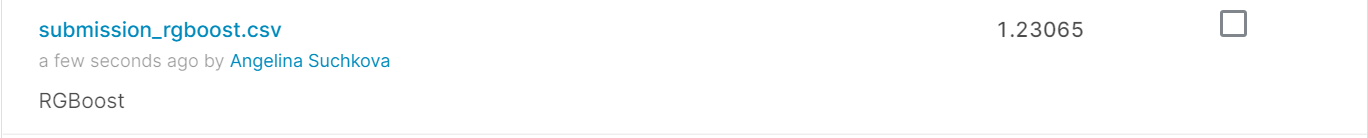

#### RMSE of the 2nd model is 1.23. It's lower than for the 1st one that's why the 2nd model predicts the sales in the shops more accurately.